Generate spectra using LGal's star formation history and chemical enrichment history using FSPS and compare to Rita's

In [1]:
import os 
import fsps
import numpy as np 
from astropy import units as U
from astropy import constants as Const
from astropy.io import fits 
from astropy.table import Table
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM
# -- fomospec
from fomospec import util as UT

In [2]:
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
def LgalInput(galid): 
    # get Lgal galaxy metadata
    f_input = os.path.join(UT.dat_dir(), 'Lgal', 'gal_inputs', 'gal_input_'+str(galid)+'_BGS_template_FSPS_uvmiles.csv')
    gal_input = Table.read(f_input, delimiter=' ')
    return gal_input

def Lgal_sourceSpectra(galid, lib='bc03'): 
    # get Lgal source spectra
    if lib == 'bc03': lib_str = 'BC03_Stelib'
    elif lib == 'fsps': lib_str = 'FSPS_uvmiles'
        
    f_spec = fits.open(''.join([UT.dat_dir(), 'Lgal/templates/',
                      'gal_spectrum_'+str(galid)+'_BGS_template_', lib_str, '.fits']))
    meta = {}
    for k in f_spec[0].header.keys():
        meta[k] = f_spec[0].header[k]

    specobj = f_spec[1].data
    spec_in = {}
    spec_in['meta'] = meta
    spec_in['redshift'] = f_spec[0].header['REDSHIFT']
    spec_in['wave'] = specobj['wave']
    spec_in['flux'] = specobj['flux_dust_nonoise'] 
    spec_in['flux_dust_nonoise'] = specobj['flux_dust_nonoise'] # W/A/m^2
    spec_in['flux_nodust_nonoise'] = specobj['flux_nodust_nonoise']
    return spec_in

In [4]:
gal_id = 298566 #2801 #315435 #320292 
gal_prop = LgalInput(gal_id)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


log M_bulge = 7.944755
log M_disk = 10.432063
log M_total = 10.433475


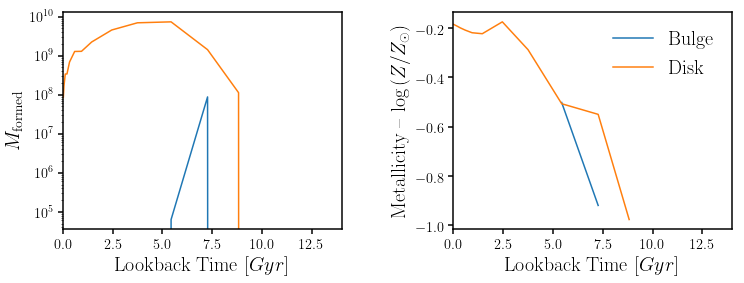

In [5]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(121)
sub.plot(gal_prop['sfh_t'], gal_prop['sfh_bulge'], label='Bulge')
sub.plot(gal_prop['sfh_t'], gal_prop['sfh_disk'], label='Disk')
sub.set_xlabel('Lookback Time [$Gyr$]', fontsize=20)
sub.set_xlim([0., 14.])
sub.set_ylabel("$M_\mathrm{formed}$", fontsize=20)
sub.set_yscale("log")
sub = fig.add_subplot(122)
sub.plot(gal_prop['sfh_t'], np.log10(gal_prop['Z_bulge']/0.0190), label='Bulge')
sub.plot(gal_prop['sfh_t'], np.log10(gal_prop['Z_disk']/0.0190), label='Disk')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Lookback Time [$Gyr$]', fontsize=20)
sub.set_xlim([0., 14.])
sub.set_ylabel('Metallicity -- $\log\,(Z/Z_\odot)$', fontsize=20)
fig.subplots_adjust(wspace=0.4)
print('log M_bulge = %f' % np.log10(np.sum(gal_prop['sfh_bulge'])))
print('log M_disk = %f' % np.log10(np.sum(gal_prop['sfh_disk'])))
print('log M_total = %f' % np.log10(np.sum(gal_prop['sfh_bulge'] + gal_prop['sfh_disk'])))

In [6]:
spec_lgal_bc03 = Lgal_sourceSpectra(gal_id, lib='bc03')
spec_lgal_fsps = Lgal_sourceSpectra(gal_id, lib='fsps')

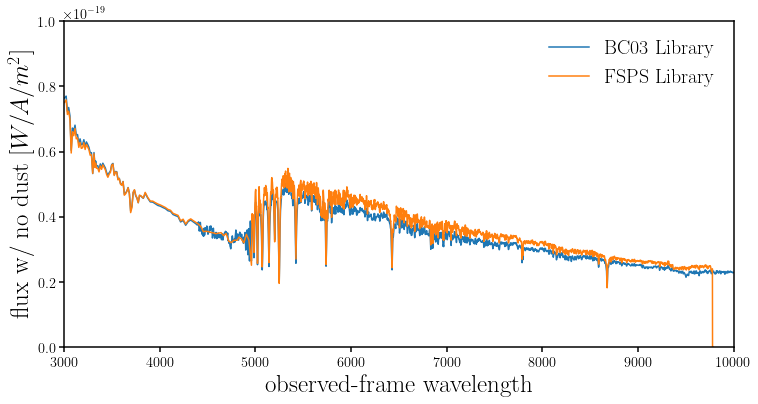

In [17]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
sub.plot(spec_lgal_bc03['wave'], spec_lgal_bc03['flux_nodust_nonoise'], label="BC03 Library")
sub.plot(spec_lgal_fsps['wave'], spec_lgal_fsps['flux_nodust_nonoise'], label="FSPS Library")
sub.set_xlabel('observed-frame wavelength', fontsize=25)
sub.set_xlim([3e3, 1e4])
sub.set_ylabel('flux w/ no dust [$W/A/m^2$]', fontsize=25)
sub.set_ylim([0., 1e-19])
sub.legend(loc='upper right', fontsize=20)

In [8]:
for loc in ['bulge', 'disk']: 
    flux_ssps = [] 
    for tage, mtot, z in zip(gal_prop['sfh_t'], gal_prop['sfh_'+loc], gal_prop['Z_'+loc]): 
        if mtot == 0: 
            continue 

        if loc == 'bulge': 
            vdisp = 10**2.073 * (np.sum(gal_prop['sfh_bulge'])/10**10.26)**0.403
        else: 
            vdisp = 50.
    
        #ssp_i = fsps.StellarPopulation(zcontinuous=0, sfh=0,  # no interpolation of metallicity
        ssp_i = fsps.StellarPopulation(zcontinuous=1, sfh=0, 
                                       logzsol=np.log10(z/0.0190), 
                                       imf_type=1, # chabrier
                                       smooth_velocity=True, 
                                       sigma_smooth=vdisp) 
        wave_rest, flux_i = ssp_i.get_spectrum(tage=tage, peraa=True)
        flux_ssps.append(flux_i * mtot)
    if loc == 'bulge': 
        flux_bulge_ssps = np.array(flux_ssps)
    elif loc == 'disk':
        flux_disk_ssps = np.array(flux_ssps)

In [9]:
wave = wave_rest * (1. + spec_lgal_fsps['redshift']) # observed-frame
flux_tot = np.sum(flux_bulge_ssps, axis=0) + np.sum(flux_disk_ssps, axis=0) # Lsun/A

In [10]:
convert = 1. #Const.c.to(U.Angstrom/U.s).value / wave_rest**2

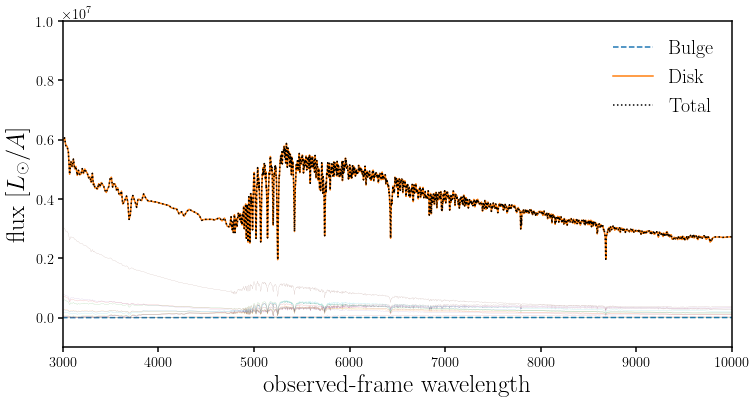

In [18]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
for fi in flux_bulge_ssps: 
    sub.plot(wave, fi * convert, ls='-', lw=0.1)
sub.plot(wave, np.sum(flux_bulge_ssps, axis=0) * convert, c='C0', ls='--', label='Bulge')
for fi in flux_disk_ssps: 
    sub.plot(wave, fi * convert, lw=0.1)
sub.plot(wave, np.sum(flux_disk_ssps, axis=0) * convert, c='C1', label='Disk')
sub.plot(wave, flux_tot * convert, c='k', ls=':', label='Total')
sub.set_xlabel('observed-frame wavelength', fontsize=25)
sub.set_xlim([3e3, 1e4])
sub.set_ylabel('flux [$L_\odot/A$]', fontsize=25)
sub.set_ylim([-1e6, 1e7])
sub.legend(loc='upper right', fontsize=20)

In [12]:
#d_lum = Planck13.luminosity_distance(spec_lgal_bc03['redshift'])
cosmo = FlatLambdaCDM(H0=67.3 * U.km / U.s / U.Mpc, Om0=0.315)
d_lum = cosmo.luminosity_distance(spec_lgal_bc03['redshift'])
print('z = %f' % spec_lgal_bc03['redshift'])
print('luminosity distance = %f Mpc' % d_lum.value)

z = 0.322074
luminosity distance = 1747.172629 Mpc


In [13]:
# in units of W/A/m^2
flux_tot_z = (flux_tot * convert * U.L_sun / U.Angstrom) / (4. * np.pi * d_lum**2 * (1 + spec_lgal_fsps['redshift']))

In [14]:
flux_tot_z.to(U.erg/U.s/U.cm**2/U.Angstrom).max()

<Quantity 1.92255163e-16 erg / (Angstrom cm2 s)>

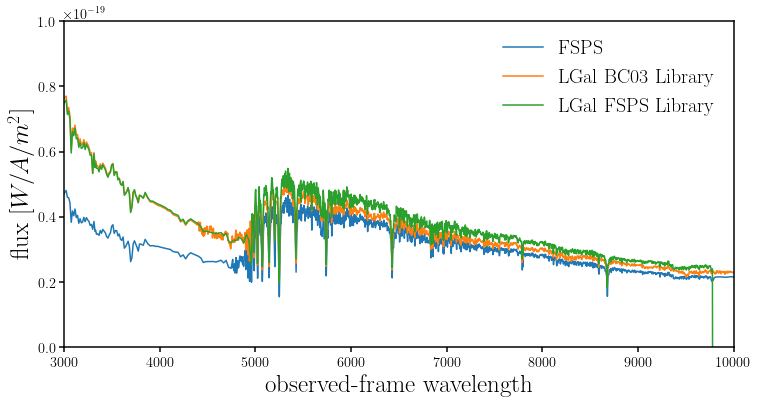

In [20]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
sub.plot(wave, flux_tot_z.to(U.Watt/U.m**2/U.Angstrom), label='FSPS')
sub.plot(spec_lgal_bc03['wave'], spec_lgal_bc03['flux_nodust_nonoise'], label="LGal BC03 Library")
sub.plot(spec_lgal_fsps['wave'], spec_lgal_fsps['flux_nodust_nonoise'], label="LGal FSPS Library")
sub.set_xlabel('observed-frame wavelength', fontsize=25)
sub.set_xlim([3e3, 1e4])
sub.set_ylabel('flux [$W/A/m^2$]', fontsize=25)
sub.set_ylim([0., 1e-19])
sub.legend(loc='upper right', fontsize=20)

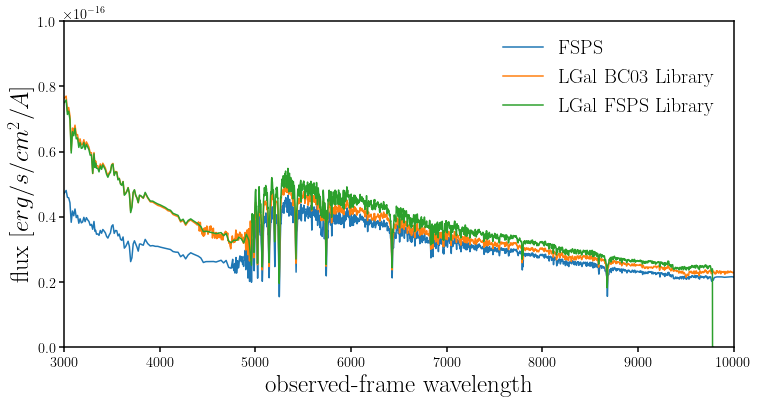

In [21]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
sub.plot(wave, flux_tot_z.to(U.erg/U.s/U.cm**2/U.Angstrom), label='FSPS')
sub.plot(spec_lgal_bc03['wave'], spec_lgal_bc03['flux_nodust_nonoise'] * 1e3, label="LGal BC03 Library")
sub.plot(spec_lgal_fsps['wave'], spec_lgal_fsps['flux_nodust_nonoise'] * 1e3, label="LGal FSPS Library")
sub.set_xlabel('observed-frame wavelength', fontsize=25)
sub.set_xlim([3e3, 1e4])
sub.set_ylabel('flux [$erg/s/cm^2/A$]', fontsize=25)
sub.set_ylim([0., 1e-16])
sub.legend(loc='upper right', fontsize=20)